Anggota Kelompok
- Abdul Rifai	22.11.4597
- Aditya Yusuf Bagas S	22.11.4550
- Dandi Arif Prastowo	22.11.4558
- Muhammad	22.11.4555
- Naufal Ananda S	22.11.4572


In [ ]:
from google.colab import output

# JavaScript code to simulate user activity
code = """
function KeepColabAlive() {
  console.log("Preventing Google Colab from disconnecting...");
  let counter = 0;
  const interval = setInterval(() => {
    console.log("Ping:", counter++);
    document.querySelector("colab-toolbar-button#connect")?.click();
  }, 60000); // Simulate activity every 60 seconds
}
KeepColabAlive();
"""
output.register_callback('keep_alive', lambda: None)
output.eval_js(code)


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier, NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import IntegerType
import pandas as pd
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.appName("BortDiamond").getOrCreate()

# Replace 'your_file.csv' with the actual path to your CSV file
file_path = 'bort_diamond.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True, sep=';')
df.show(5)

+-----+-------+-----+-------+-----+-----+---+---+---+-----+
|carat|    cut|color|clarity|depth|table|  x|  y|  z|price|
+-----+-------+-----+-------+-----+-----+---+---+---+-----+
|   23|  Ideal|    E|    SI2|  615|   55|395|398|243|  326|
|   21|Premium|    E|    SI1|  598|   61|389|384|231|  326|
|   23|   Good|    E|    VS1|  569|   65|405|407|231|  327|
|   29|Premium|    I|    VS2|  624|   58| 42|423|263|  334|
|   31|   Good|    J|    SI2|  633|   58|434|435|275|  335|
+-----+-------+-----+-------+-----+-----+---+---+---+-----+
only showing top 5 rows



# Data Preprocessing

root
 |-- carat: integer (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: integer (nullable = true)
 |-- table: integer (nullable = true)
 |-- x: integer (nullable = true)
 |-- y: integer (nullable = true)
 |-- z: integer (nullable = true)
 |-- harga: integer (nullable = true)

+-----+---+-----+-------+-----+-----+---+---+---+-----+
|carat|cut|color|clarity|depth|table|  x|  y|  z|harga|
+-----+---+-----+-------+-----+-----+---+---+---+-----+
|    0|  0|    0|      0|    0|    0|  0|  0|  0|    0|
+-----+---+-----+-------+-----+-----+---+---+---+-----+

+-------+------------------+---------+-----+-------+------------------+-----------------+------------------+-----------------+------------------+-----------------+
|summary|             carat|      cut|color|clarity|             depth|            table|                 x|                y|                 z|            harga|
+-------+-----------

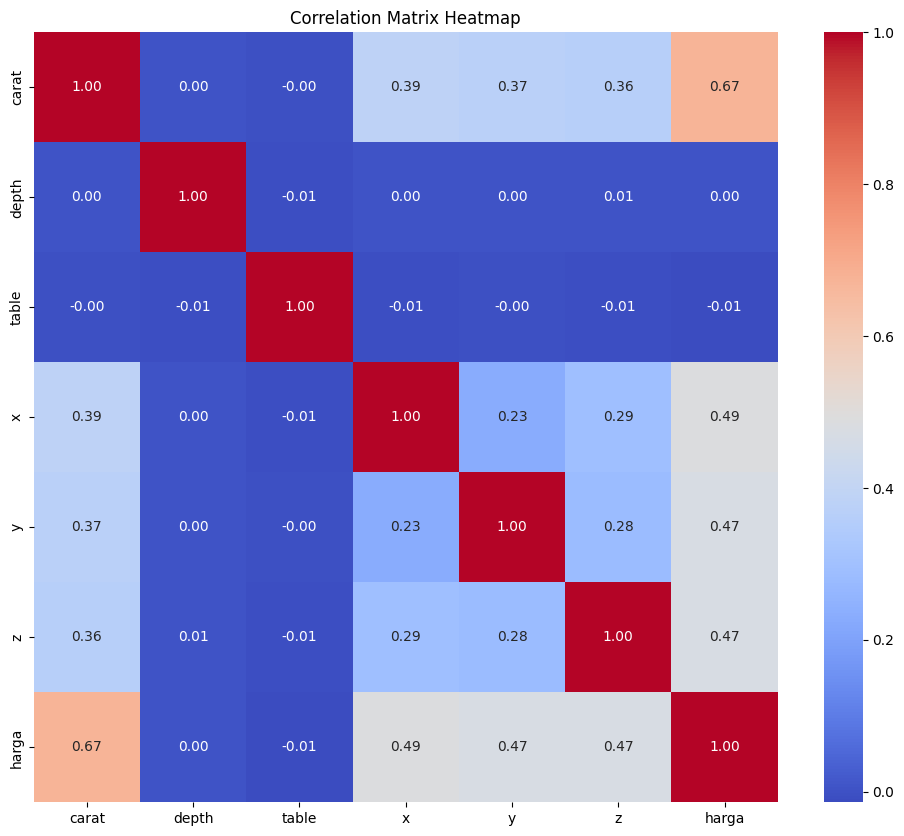

In [ ]:
# Data Preprocessing

# 1. Mengecheck tipe data
df.printSchema()

# 2. Rename columns (example: rename 'column1' to 'Column_1')
df = df.withColumnRenamed("price", "harga")

# 3. Check for null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# 4. Display summary statistics
df.describe().show()

# Show the first 5 rows after preprocessing
df.show(5)

# Menampilkan korelasi matriks
pandas_df = df.toPandas()
numerical_features = pandas_df.select_dtypes(include=['number'])
correlation_matrix = numerical_features.corr()
# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

# EDA

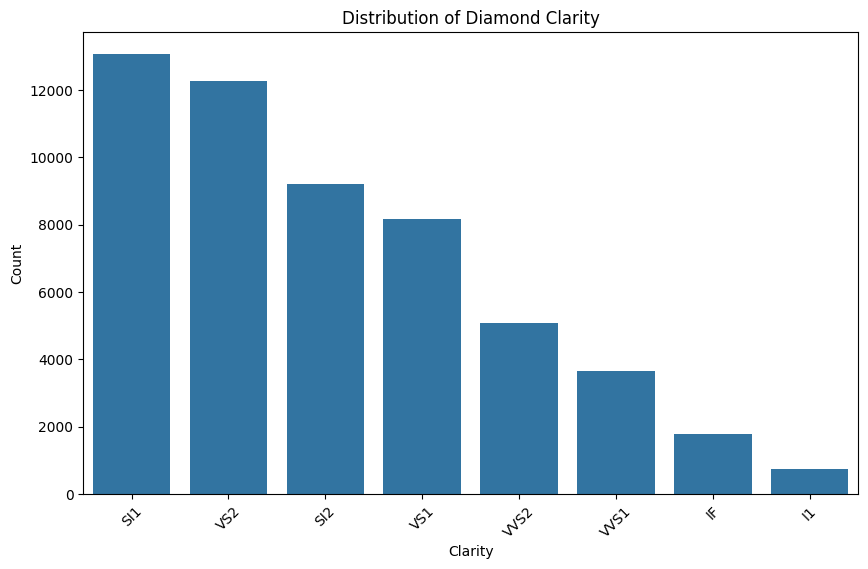

In [ ]:
# --- Bar Chart: Price Distribution by Clarity ---
plt.figure(figsize=(10, 6))
sns.countplot(x='clarity', data=pandas_df, order=pandas_df['clarity'].value_counts().index)  # Order bars by frequency
plt.title('Distribution of Diamond Clarity')
plt.xlabel('Clarity')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

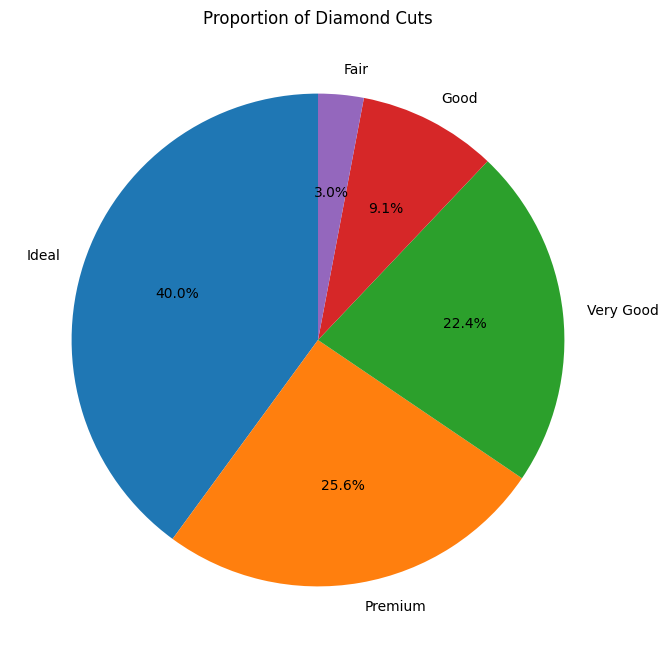

In [ ]:
# --- Pie Chart: Proportion of Diamond Cuts ---
plt.figure(figsize=(8, 8))
pandas_df['cut'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Diamond Cuts')
plt.ylabel('') # Hide the y-axis label
plt.show()

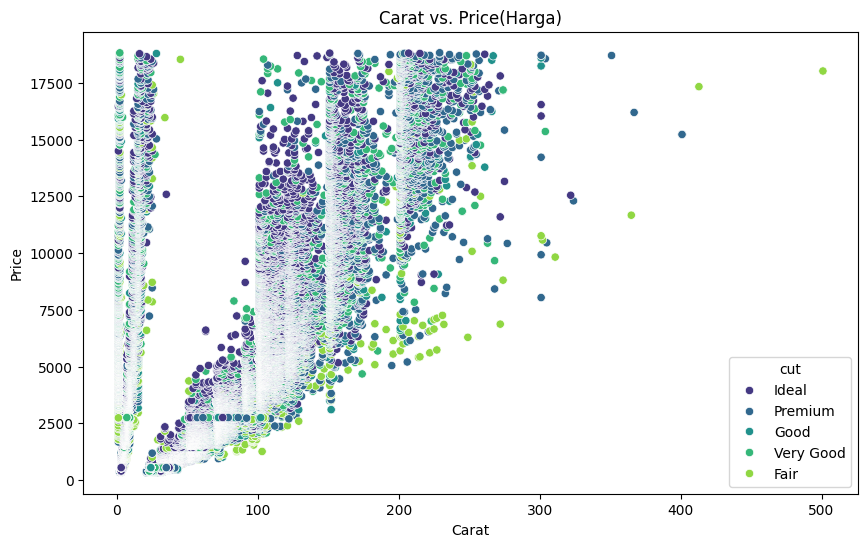

In [ ]:
# --- Scatter Plot: carat vs. price ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='carat', y='harga', data=pandas_df, hue='cut', palette='viridis')
plt.title('Carat vs. Price(Harga)')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.show()

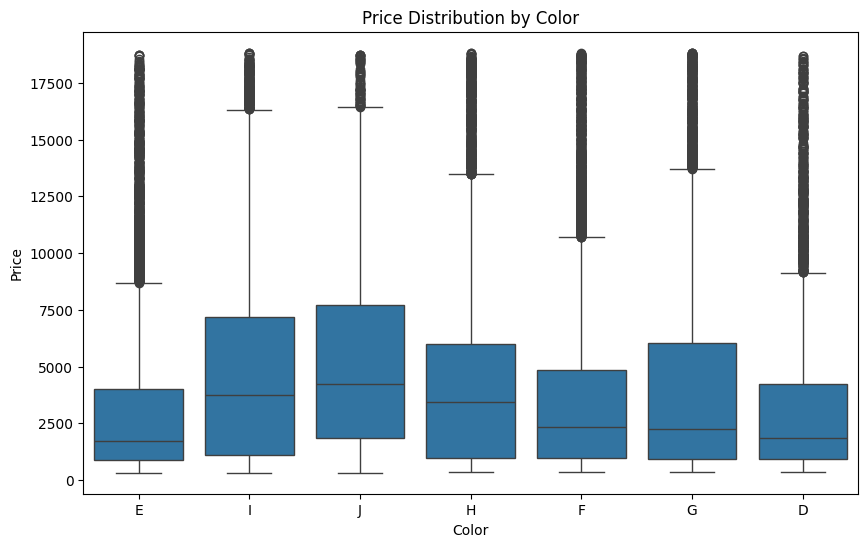

In [ ]:
# --- Box Plot: Price Distribution by Color ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='color', y='harga', data=pandas_df)
plt.title('Price Distribution by Color')
plt.xlabel('Color')
plt.ylabel('Price')
plt.show()

# PENGEMBANGAN MODEL MACHINE LEARNING

In [ ]:
# Ubah dulu tipe data kolom cut menggunakan encoding supaya memudahkan proses machine learning serta filter hanya untuk
# very good dan premium saja
#Very Good = 0
#Premium = 1

# Filter the DataFrame to keep only 'Very Good' and 'Premium' cuts
filtered_df = df.filter(df["cut"].isin(["Very Good", "Premium"]))

# Re-encode the 'cut' column for the filtered data
indexer = StringIndexer(
    inputCol="cut",
    outputCol="cut_encoded",
    stringOrderType="alphabetAsc"  # Ensures 'Premium' is 1 and 'Very Good' is 0
)

filtered_df = indexer.fit(filtered_df).transform(filtered_df)
# Cast 'cut_encoded' to IntegerType
filtered_df = filtered_df.withColumn("cut_encoded", filtered_df["cut_encoded"].cast(IntegerType()))
filtered_df.show(5)

+-----+---------+-----+-------+-----+-----+---+---+---+-----+-----------+-----------+
|carat|      cut|color|clarity|depth|table|  x|  y|  z|harga|cut_dicoded|cut_encoded|
+-----+---------+-----+-------+-----+-----+---+---+---+-----+-----------+-----------+
|   21|  Premium|    E|    SI1|  598|   61|389|384|231|  326|          1|          0|
|   29|  Premium|    I|    VS2|  624|   58| 42|423|263|  334|          1|          0|
|   24|Very Good|    J|   VVS2|  628|   57|394|396|248|  336|          2|          1|
|   24|Very Good|    I|   VVS1|  623|   57|395|398|247|  336|          2|          1|
|   26|Very Good|    H|    SI1|  619|   55|407|411|253|  337|          2|          1|
+-----+---------+-----+-------+-----+-----+---+---+---+-----+-----------+-----------+
only showing top 5 rows



In [ ]:
filtered_df = filtered_df.drop("cut_dicoded")

In [ ]:
filtered_df.show(5)

+-----+---------+-----+-------+-----+-----+---+---+---+-----+-----------+
|carat|      cut|color|clarity|depth|table|  x|  y|  z|harga|cut_encoded|
+-----+---------+-----+-------+-----+-----+---+---+---+-----+-----------+
|   21|  Premium|    E|    SI1|  598|   61|389|384|231|  326|          0|
|   29|  Premium|    I|    VS2|  624|   58| 42|423|263|  334|          0|
|   24|Very Good|    J|   VVS2|  628|   57|394|396|248|  336|          1|
|   24|Very Good|    I|   VVS1|  623|   57|395|398|247|  336|          1|
|   26|Very Good|    H|    SI1|  619|   55|407|411|253|  337|          1|
+-----+---------+-----+-------+-----+-----+---+---+---+-----+-----------+
only showing top 5 rows



In [ ]:
# 1. Persiapan Data
# Tentukan features (input) dan target (label)
feature_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
target_col = 'cut_encoded'  # Kolom 'cut' yang sudah di-encode

In [ ]:
# 2. Bagi Data Menjadi Training dan Testing
(training_data, test_data) = filtered_df.randomSplit([0.7, 0.3], seed=123)

In [ ]:
# 3. Definisikan Model-model
# Random Forest
rf = RandomForestClassifier(labelCol=target_col, featuresCol="features")
# Gradient Boost Tree
gbt = GBTClassifier(labelCol=target_col, featuresCol="features")
# Multilayer Perceptron Classifier
layers = [len(feature_cols), 5, 4, 5]  # Tentukan jumlah layer dan neuron
mlp = MultilayerPerceptronClassifier(labelCol=target_col, featuresCol="features", layers=layers)
# Naïve Bayes
nb = NaiveBayes(labelCol=target_col, featuresCol="features")
# Buat VectorAssembler untuk menggabungkan features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [ ]:
# 4. Buat Pipeline untuk Setiap Model
# Random Forest Pipeline
rf_pipeline = Pipeline(stages=[assembler, rf])
# Gradient Boost Tree Pipeline
gbt_pipeline = Pipeline(stages=[assembler, gbt])
# Multilayer Perceptron Classifier Pipeline
mlp_pipeline = Pipeline(stages=[assembler, mlp])
# Naïve Bayes Pipeline
nb_pipeline = Pipeline(stages=[assembler, nb])

In [ ]:
# 5. Latih Model-model
rf_model = rf_pipeline.fit(training_data)
gbt_model = gbt_pipeline.fit(training_data)
mlp_model = mlp_pipeline.fit(training_data)
nb_model = nb_pipeline.fit(training_data)

In [ ]:
# 6. Prediksi pada Data Testing
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)
mlp_predictions = mlp_model.transform(test_data)
nb_predictions = nb_model.transform(test_data)

In [ ]:
# 7. Evaluasi Model
evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction")

In [ ]:
# Hitung metrik untuk setiap model
models = [rf_model, gbt_model, mlp_model, nb_model]
model_names = ["Random Forest", "Gradient Boost Tree", "Multilayer Perceptron", "Naïve Bayes"]
metrics = ["accuracy", "f1", "weightedPrecision", "weightedRecall"]

In [ ]:
for model, name in zip(models, model_names):
    predictions = model.transform(test_data)
    print(f"--- {name} ---")
    for metric in metrics:
        value = evaluator.evaluate(predictions, {evaluator.metricName: metric})
        print(f"{metric}: {value}")
    print("\n")

--- Random Forest ---
accuracy: 0.736835426976272
f1: 0.7270359777254172
weightedPrecision: 0.7592408841919953
weightedRecall: 0.736835426976272


--- Gradient Boost Tree ---
accuracy: 0.7535845704859789
f1: 0.7470659891487006
weightedPrecision: 0.7688960471431161
weightedRecall: 0.7535845704859789


--- Multilayer Perceptron ---
accuracy: 0.5462504758279406
f1: 0.47333024082850594
weightedPrecision: 0.5515890325652604
weightedRecall: 0.5462504758279406


--- Naïve Bayes ---
accuracy: 0.5358457048597893
f1: 0.5347806837405135
weightedPrecision: 0.5419634342378208
weightedRecall: 0.5358457048597893




# TUNING
Berdasarkan hasil evaluasi, disimpulkan bahwa GBT dan RandomForest merupakan 2 model dengan performa terbaik

In [ ]:
# 1. Tentukan parameter grid untuk Random Forest
rf_param_grid = (ParamGridBuilder()
                  .addGrid(rf.numTrees, [10, 20, 30])  # Jumlah pohon
                  .addGrid(rf.maxDepth, [5, 10, 15])  # Kedalaman maksimum pohon
                  .build())

In [ ]:
# 2. Tentukan parameter grid untuk Gradient Boost Tree
gbt_param_grid = (ParamGridBuilder()
                   .addGrid(gbt.maxIter, [10, 20, 30])  # Jumlah iterasi
                   .addGrid(gbt.maxDepth, [3, 5, 7])  # Kedalaman maksimum pohon
                   .build())

In [ ]:
# 3. Buat CrossValidator untuk Random Forest
rf_crossval = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=rf_param_grid,
                          evaluator=evaluator,
                          numFolds=3)  # Jumlah lipatan cross-validation

In [ ]:
# 4. Buat CrossValidator untuk Gradient Boost Tree
gbt_crossval = CrossValidator(estimator=gbt_pipeline,
                           estimatorParamMaps=gbt_param_grid,
                           evaluator=evaluator,
                           numFolds=3)


In [ ]:
# 5. Latih model dengan hyperparameter tuning
rf_tuned_model = rf_crossval.fit(training_data)
gbt_tuned_model = gbt_crossval.fit(training_data)

In [ ]:
# 6. Evaluasi model yang sudah di-tuning
rf_tuned_predictions = rf_tuned_model.transform(test_data)
gbt_tuned_predictions = gbt_tuned_model.transform(test_data)

rf_tuned_accuracy = evaluator.evaluate(rf_tuned_predictions, {evaluator.metricName: "accuracy"})
gbt_tuned_accuracy = evaluator.evaluate(gbt_tuned_predictions, {evaluator.metricName: "accuracy"})

print(f"Random Forest Tuned Accuracy: {rf_tuned_accuracy}")
print(f"Gradient Boost Tree Tuned Accuracy: {gbt_tuned_accuracy}")

Random Forest Tuned Accuracy: 0.7664002030199213
Gradient Boost Tree Tuned Accuracy: 0.7771856363405659


In [ ]:
# 7. Tentukan model terbaik
best_model = rf_tuned_model if rf_tuned_accuracy > gbt_tuned_accuracy else gbt_tuned_model